# XID+PACS EGS Prior

In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table , join
from mocpy import MOC
from astropy.io import fits
from astropy import wcs

In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+PACS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources.

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_EGS/data/holes_EGS_irac_i1_O16_20190201_WARNING-MADE-WITH-Lockman-SWIRE-PARAMS.fits')


In [4]:
#Final.write('./data/testMoc.fits', overwrite=True)
#Final=pymoc.MOC()
#Final.read('./data/testMoc.fits')

## Read in CIGALE predictions catalogue

In [5]:
cigale=Table.read('../../dmu28/dmu28_EGS/data/EGS_Ldust_prediction.fits')

In [6]:
cigale['id'].name = 'help_id'

In [7]:
cigale

help_id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.mmt_u,best.megacam_u,best.cfht12k_b,best.mmt_g,best.suprime_g,best.90prime_g,best.megacam_g,best.gpc1_g,best.acs_f606w,best.suprime_r,best.gpc1_r,best.megacam_r,best.90prime_r,best.suprime_rc,best.cfht12k_r,best.gpc1_i,best.megacam_i,best.suprime_i,best.mmt_i,best.acs_f814w,best.cfht12k_i,best.gpc1_z,best.megacam_z,best.suprime_z,best.mmt_z,best.mosaic_z,best.gpc1_y,best.suprime_y,best.nicmos_f110w,best.wircs_j,best.omega2000_j,best.ukidss_j,best.newfirm_j3,best.newfirm_j1,best.newfirm_j2,best.wfc3_f125w,best.wircam_j,best.wfc3_f140w,best.wfc3_f160w,best.nicmos_f160w,best.wircam_h,best.newfirm_h2,best.newfirm_h1,best.omega2000_ks,best.newfirm_k,best.wircs_k,best.moircs_ks,best.wircam_ks,best.irac_i1,best.irac_i2,best.irac_i3,best.irac_i4
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J141033.653+515516.209,3428864143.389563,2887491658.373124,16.64529587470418,30.244329878811246,4.273412039696369e+37,6.447224265190918e+37,1.3526330588990938e+38,2.4788985703529

## Read in photoz

In [8]:
photoz=Table.read('../../dmu24/dmu24_EGS/data/master_catalogue_egs_20180501_photoz_20180608.fits')

In [9]:
photoz

help_id,RA,DEC,id,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,za_hb,chi_r_eazy,chi_r_atlas,chi_r_cosmos,chi_r_stellar,stellar_type
bytes27,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6
HELP_J141604.525+522314.318,214.01885343855852,52.38731062037661,1,0.3287,0.2017,0.46,0.79,-99.0,-99.0,-99.0,-99.0,0.3107445158917243,0.00941402,0.005750465,0.038778125,1.16068175,k4i
HELP_J141625.630+515253.992,214.10679106334706,51.881664522183016,2,0.3341,0.1838,0.4776,0.797,-99.0,-99.0,-99.0,-99.0,0.3186207796877177,0.172925325,0.057914225,0.093599325,1.79632475,m2v
HELP_J141911.366+530320.518,214.79735831765808,53.05569947987607,3,0.3557,0.1874,0.5225,0.791,-99.0,-99.0,-99.0,-99.0,0.3465622852301831,0.0053131625,0.03812535,0.0809428,2.155046,k5iii
HELP_J141525.065+522526.822,213.85443844608528,52.42411731941239,4,0.4947,0.3958,0.6165,0.433,0.2238,0.1284,0.299,0.358,0.42542435154728503,0.024677515,0.13246265,0.1400433,5.7028675,wg8iii
HELP_J141943.168+523158.983,214.92986686469408,52.53305086665113,5,0.2834,0.1183,0.4426,0.797,-99.0,-99.0,-99.0,-99.0,0.2912590674014151,0.00083104725,0.1810521,0.123727875,3.5283325,rk0v
HELP_J141848.923+525921.139,214.70384569336562,52.98920527391837,6,0.3486,0.1803,0.5225,0.79,-99.0,-99.0,-99.0,-99.0,0.2990182431374302,0.0020962585,0.0013756125,0.0577491,0.91910475,wk3iii
HELP_J142111.698+522044.991,215.29874092601307,52.345830748462134,7,0.4852,0.2721,0.6607,0.794,-99.0,-99.0,-99.0,-99.0,0.5270935167224258,0.0397356,0.233541025,0.39683775,1.8079045,m3iii
HELP_J141322.317+522430.572,213.3429865295886,52.40849213212558,8,0.3965,0.1909,0.5877,0.793,-99.0,-99.0,-99.0,-99.0,0.42542435154728503,0.000403126,0.014958385,0.0261745,5.6493875,wk3iii
HELP_J141553.974+523158.605,213.97489187629904,52.53294582179002,9,0.4897,0.3385,0.6458,0.791,-99.0,-99.0,-99.0,-99.0,0.49093314336472166,0.0200424975,0.00545671,0.0926184,5.765695,m2i


## Join CIGALE and photoz tables

In [10]:
prior=join(cigale,photoz,keys='help_id')

In [11]:
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
f_pred=prior['bayes.dust.luminosity']/(4*np.pi*cosmo.luminosity_distance(prior['z1_median']).to(u.cm))


In [12]:
prior=prior[np.isfinite(f_pred.value)][np.log10(f_pred.value[np.isfinite(f_pred.value)])>8.5]

In [13]:
prior['DEC'].name='Dec'

## Read in Maps

In [14]:
im100fits='../../dmu18/dmu18_HELP-PACS-maps/data/EGS_PACS100_v0.9.fits'
im160fits='../../dmu18/dmu18_HELP-PACS-maps/data/EGS_PACS160_v0.9.fits'
#output folder
output_folder='./'

In [15]:
from astropy.io import fits
from astropy import wcs


#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100hdu=hdulist['IMAGE'].header
im100=hdulist['IMAGE'].data
w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160hdu=hdulist['IMAGE'].header
im160=hdulist['IMAGE'].data
w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data

hdulist.close()



## Read in PSF

In [17]:
pacs100_psf=fits.open('../../dmu18/dmu18_EGS/data/dmu18_PACS_100_PSF_EGS_20190125.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_EGS/data/dmu18_PACS_160_PSF_EGS_20190125.fits')

centre100=np.long((pacs100_psf[0].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[0].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map

In [18]:
print(pind100)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


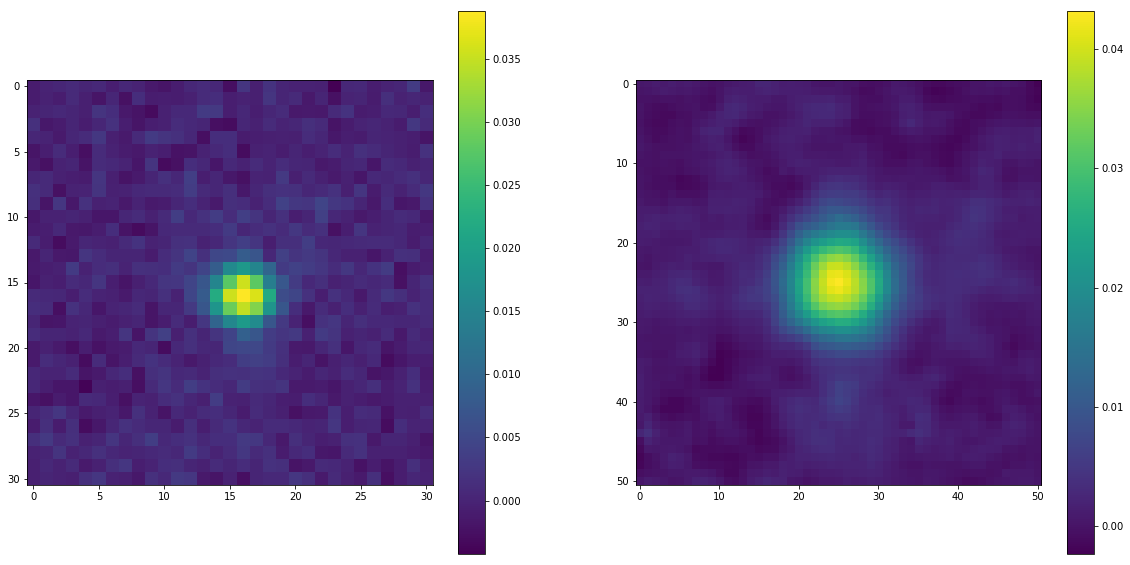

In [19]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

## Set XID+ prior class

In [20]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(prior['RA'] ,prior['Dec'] ,'EGS_Ldust_prediction',ID=prior['help_id'])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Sel_func)
prior160.prior_cat(prior['RA'] ,prior['Dec'] ,'EGS_Ldust_prediction',ID=prior['help_id'])
prior160.prior_bkg(0.0,5)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [21]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [22]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
xidplus.io.pickle_dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},'Master_prior.pkl')
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 4507 tiles required for input catalogue and 11 large tiles
writing total_bytes=412763247...
writing bytes [0, 412763247)... done.


SystemExit: 

In [18]:
ls -ltrh

total 1525656
drwxr-xr-x@ 3 pdh21  pdh21   102B 14 Feb 16:33 data/
-rw-rw-r--  1 pdh21  pdh21    41K 15 Feb 11:16 XID+PACS_prior.ipynb
-rw-rw-r--  1 pdh21  pdh21    18K 15 Feb 11:25 Tiles.pkl
-rw-rw-r--  1 pdh21  pdh21   745M 15 Feb 11:25 Master_prior.pkl


In [24]:
import gc
gc.collect()

31